# Data Loading

In [1]:
from scipy import stats
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedShuffleSplit,
    GridSearchCV
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from utils import custom_calculate_f1_score, get_all_metrics, TorchKFoldCrossValidation
import torch
from torch import nn
from torch.utils.data import TensorDataset
from torchinfo import summary

In [2]:
df = pd.read_csv('./dataset/Dry_Bean_Dataset.csv')
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [3]:
## Dataset is multi-class, but we will convert it to binary
df['Class'] = df['Class'].apply(lambda x: 'DERMASON' if x == 'DERMASON' else 'Non-DERMASON')

# Data analysis

### Check for nullish values

The isna function checks if there are any nullish values in the dataframe or not

In [4]:
df.isna().any()

Area               False
Perimeter          False
MajorAxisLength    False
MinorAxisLength    False
AspectRation       False
Eccentricity       False
ConvexArea         False
EquivDiameter      False
Extent             False
Solidity           False
roundness          False
Compactness        False
ShapeFactor1       False
ShapeFactor2       False
ShapeFactor3       False
ShapeFactor4       False
Class              False
dtype: bool

### Data distribution

From the histograms below, it can be observed that the value range of the attributes are high and needs to be standardized for ML models to converge faster

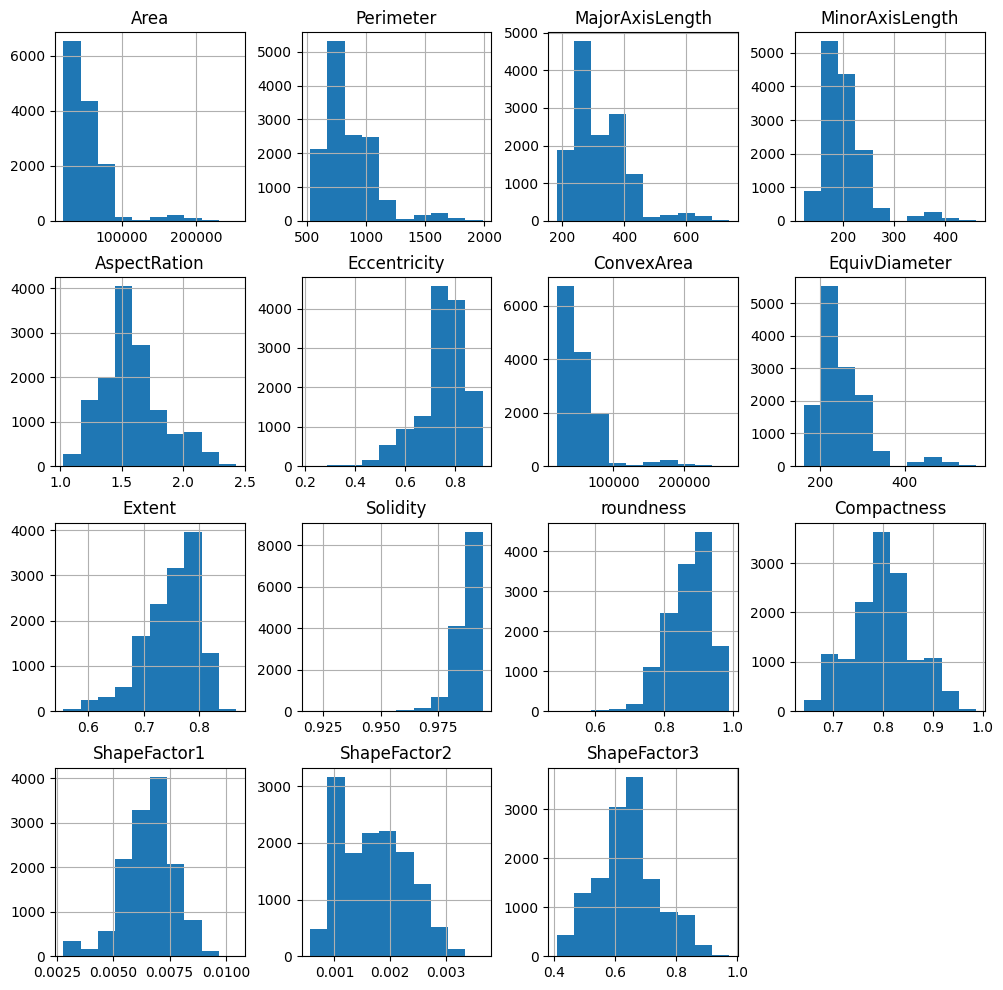

In [5]:
_ = df.iloc[:, :-2].hist(figsize=(12, 12))

### Correlations

From the correlations heatmap below, it can be observed:
1. Some features have very high correlation with other variables (so they are not independent)
2. Some attributes like Area, Perimeter, MajorAxisLength, MinorAxisLength, etc have direct correlation to some extent with labels

In [6]:
class_factorized_df = pd.concat([df.iloc[:, :-1], pd.Series(df['Class'].factorize()[0], name='Class')], axis=1)
class_factorized_df.corr().style.background_gradient(cmap='coolwarm')

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
Area,1.000000,0.966722,0.931834,0.951602,0.241735,0.267481,0.999939,0.984968,0.054345,-0.196585,-0.357530,-0.268067,-0.847958,-0.639291,-0.272145,-0.355721,-0.423657
Perimeter,0.966722,1.000000,0.977338,0.913179,0.385276,0.391066,0.967689,0.991380,-0.021160,-0.303970,-0.547647,-0.406857,-0.864623,-0.767592,-0.408435,-0.429310,-0.526502
MajorAxisLength,0.931834,0.977338,1.000000,0.826052,0.550335,0.541972,0.932607,0.961733,-0.078062,-0.284302,-0.596358,-0.568377,-0.773609,-0.859238,-0.568185,-0.482527,-0.509699
MinorAxisLength,0.951602,0.913179,0.826052,1.000000,-0.009161,0.019574,0.951339,0.948539,0.145957,-0.155831,-0.210344,-0.015066,-0.947204,-0.471347,-0.019326,-0.263749,-0.483278
AspectRation,0.241735,0.385276,0.550335,-0.009161,1.000000,0.924293,0.243301,0.303647,-0.370184,-0.267754,-0.766979,-0.987687,0.024593,-0.837841,-0.978592,-0.449264,-0.223234
Eccentricity,0.267481,0.391066,0.541972,0.019574,0.924293,1.000000,0.269255,0.318667,-0.319362,-0.297592,-0.722272,-0.970313,0.019920,-0.860141,-0.981058,-0.449354,-0.092021
ConvexArea,0.999939,0.967689,0.932607,0.951339,0.243301,0.269255,1.000000,0.985226,0.052564,-0.206191,-0.362083,-0.269922,-0.847950,-0.640862,-0.274024,-0.362049,-0.424024
EquivDiameter,0.984968,0.991380,0.961733,0.948539,0.303647,0.318667,0.985226,1.000000,0.028383,-0.231648,-0.435945,-0.327650,-0.892741,-0.713069,-0.330389,-0.392512,-0.515374
Extent,0.054345,-0.021160,-0.078062,0.145957,-0.370184,-0.319362,0.052564,0.028383,1.000000,0.191389,0.344411,0.354212,-0.141616,0.237956,0.347624,0.148502,0.038942
Solidity,-0.196585,-0.303970,-0.284302,-0.155831,-0.267754,-0.297592,-0.206191,-0.231648,0.191389,1.000000,0.607150,0.303766,0.153388,0.343559,0.307662,0.702163,0.137966


### Label distribution

From the below bar graph, we can infer following points:
1. There aren't any out-of-place/nullish class values
2. We need to convert the string values of class to numerical representation
3. The class distribution is unbalanced, so the training data needs to be split with stratification.

<Axes: xlabel='Class'>

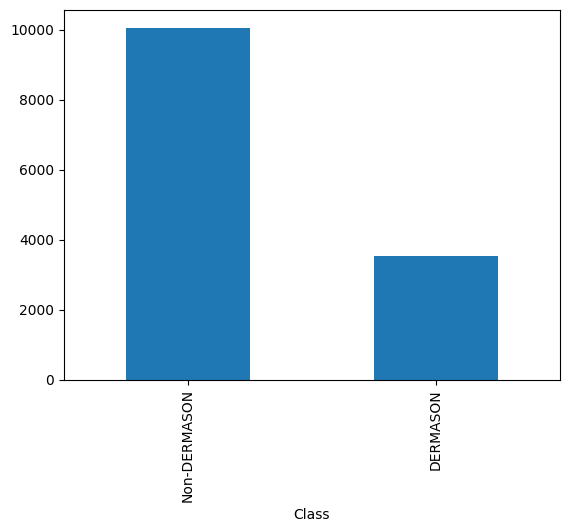

In [7]:
df['Class'].value_counts().plot(kind='bar')

# Data Preprocessing

### Converting string to numerical representation

In [8]:
encoder = LabelEncoder()
df['Class_numerical'] = encoder.fit_transform(df['Class'])

In [9]:
encoder.inverse_transform([0, 1])

array(['DERMASON', 'Non-DERMASON'], dtype=object)

### Normalizing dataset

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:, :-2],
    df["Class_numerical"],
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=df["Class_numerical"],
)

In [11]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X_train)
X_train = pd.DataFrame(scaled_features, columns=df.columns[:-2])
X_test = pd.DataFrame(scaler.transform(X_test), columns=df.columns[:-2])
X_train.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
0,-0.094682,0.123942,0.534241,-0.594340,2.031821,1.374019,-0.099211,-0.001218,-0.114303,0.462137,-1.022080,-1.756226,0.630856,-1.156022,-1.671171,0.369200
1,0.878664,1.006483,1.163613,0.850757,0.655072,0.743798,0.868142,1.074000,0.643785,0.584813,-0.178636,-0.738280,-1.089141,-1.092138,-0.753530,-0.541939
2,-0.692833,-0.941668,-1.172820,-0.268002,-1.735064,-2.703900,-0.696906,-0.823466,-0.069434,0.889031,1.534785,2.103855,0.121343,2.297855,2.228919,0.873688
3,-0.224897,-0.212262,-0.184148,-0.158521,-0.095074,0.178891,-0.229717,-0.166248,-0.094418,0.579471,0.286425,-0.011595,-0.011651,-0.113542,-0.049872,0.228672
4,-0.211924,-0.156527,-0.107921,-0.217161,0.129117,0.372271,-0.210366,-0.149512,-0.200857,-0.266950,-0.025981,-0.231699,0.064534,-0.262659,-0.267274,0.350360


As you can see in below histograms, the range of features are normalized

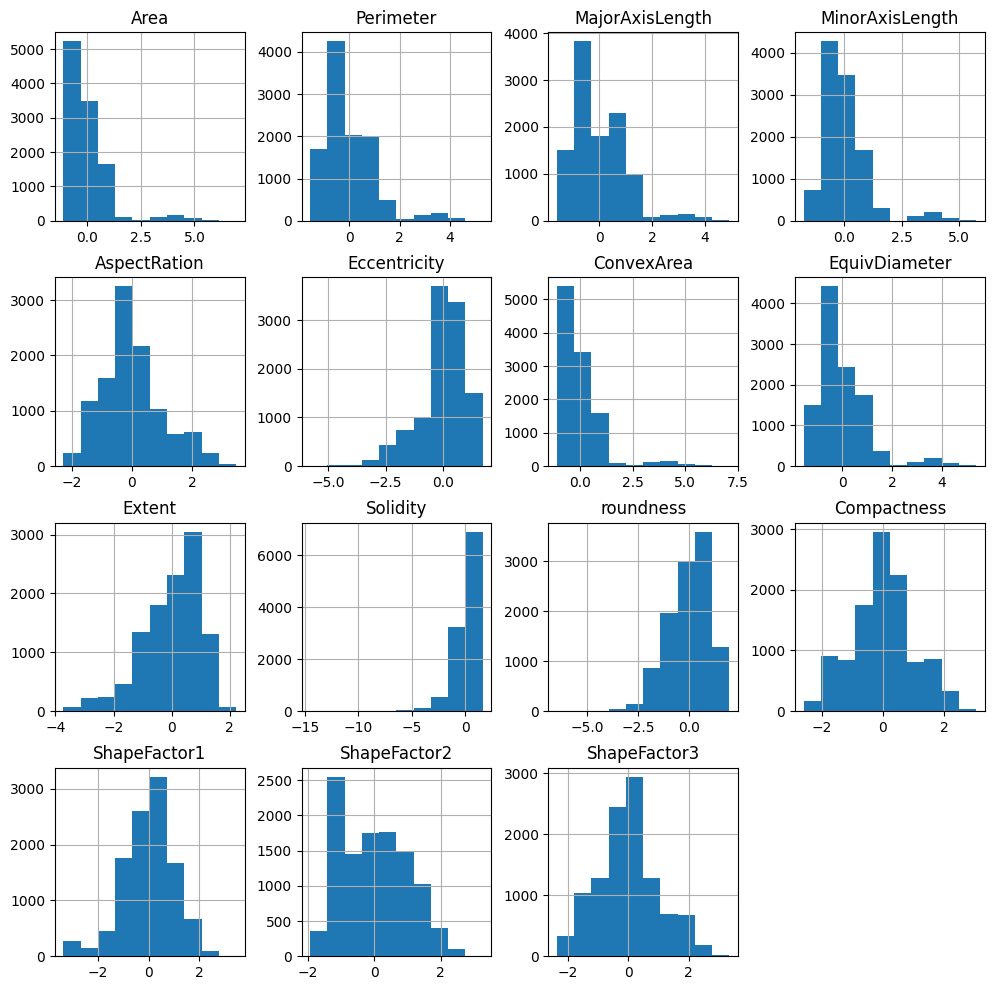

In [12]:
_ = X_train.iloc[:, :-1].hist(figsize=(12, 12))

# Model Training

In [13]:
results_comparison = pd.DataFrame({'RandomForest': {}, 'SVM': {}, 'KNN': {}, 'Conv1D-NN': {}})

## Random Forest

In [14]:
# params = {
#     "n_estimators": [100, 200, 300, 400],
#     "max_depth": [8, 10, 12],
#     "ccp_alpha": [5e-4, 1e-3],
# }
stratified_split = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
# gridsearch_rf = GridSearchCV(
#     RandomForestClassifier(n_jobs=-1),
#     params,
#     cv=stratified_split,
#     n_jobs=-1,
#     verbose=1,
#     scoring=custom_calculate_f1_score
# )
# gridsearch_rf.fit(X_train, y_train)
# gridsearch_rf.best_params_

# If you uncomment the commented code above, you will get the following output
# Output - {'ccp_alpha': 0.0005, 'max_depth': 12, 'n_estimators': 300}

Fitting 10 folds for each of 24 candidates, totalling 240 fits


{'ccp_alpha': 0.0005, 'max_depth': 12, 'n_estimators': 400}

In [15]:
random_forest_cv = {}
random_forest_cv_models = []

for i, (train_index, test_index) in enumerate(stratified_split.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    random_forest = RandomForestClassifier(n_estimators=300, max_depth=12, ccp_alpha=5e-4, n_jobs=-1)
    random_forest.fit(X_train_fold, y_train_fold)
    
    y_pred = random_forest.predict(X_val_fold)
    y_pred_proba = random_forest.predict_proba(X_val_fold)[:, 1]
    random_forest_cv[i+1] = get_all_metrics(y_val_fold, y_pred)
    random_forest_cv[i+1]['Brier Score'] = np.mean((y_pred_proba - y_val_fold)**2)
    random_forest_cv[i+1]['Brier Skill Score'] = random_forest_cv[i+1]['Brier Score'] / (np.mean((y_val_fold - np.mean(y_pred_proba))**2))
    random_forest_cv_models.append(random_forest)

random_forest_cv['mean'] = pd.DataFrame(random_forest_cv).mean(axis=1)
pd.DataFrame(random_forest_cv).round(4)

,1,2,3,4,5,6,7,8,9,10,mean
TP,260.0000,263.0000,257.0000,258.0000,262.0000,263.0000,261.0000,254.0000,258.0000,268.0000,260.4000
TN,776.0000,777.0000,783.0000,782.0000,784.0000,786.0000,778.0000,780.0000,785.0000,785.0000,781.6000
FP,29.0000,28.0000,22.0000,23.0000,21.0000,19.0000,27.0000,25.0000,20.0000,20.0000,23.4000
FN,24.0000,21.0000,27.0000,26.0000,22.0000,21.0000,23.0000,30.0000,26.0000,16.0000,23.6000
P,284.0000,284.0000,284.0000,284.0000,284.0000,284.0000,284.0000,284.0000,284.0000,284.0000,284.0000
N,805.0000,805.0000,805.0000,805.0000,805.0000,805.0000,805.0000,805.0000,805.0000,805.0000,805.0000
TPR,0.9155,0.9261,0.9049,0.9085,0.9225,0.9261,0.9190,0.8944,0.9085,0.9437,0.9169
TNR,0.9640,0.9652,0.9727,0.9714,0.9739,0.9764,0.9665,0.9689,0.9752,0.9752,0.9709
FPR,0.0360,0.0348,0.0273,0.0286,0.0261,0.0236,0.0335,0.0311,0.0248,0.0248,0.0291
FNR,0.0845,0.0739,0.0951,0.0915,0.0775,0.0739,0.0810,0.1056,0.0915,0.0563,0.0831


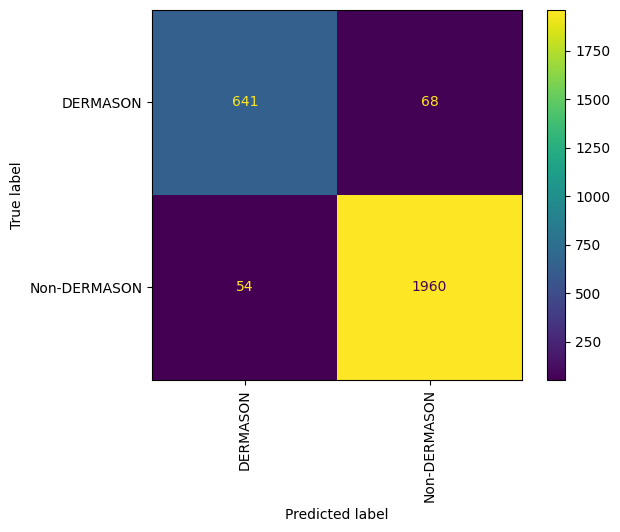

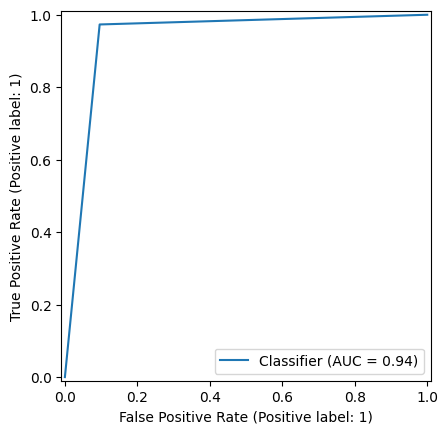

In [16]:
# Mode function returns the values that appear most frequently in the array
y_pred = stats.mode([model.predict(X_test) for model in random_forest_cv_models]).mode

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=encoder.inverse_transform([0, 1]),
    xticks_rotation="vertical",
)

RocCurveDisplay.from_predictions(y_test, y_pred)

results_comparison['RandomForest'] = get_all_metrics(y_test, y_pred)
results_comparison.loc["Brier Score", "RandomForest"] = np.mean((y_pred - y_test) ** 2)
results_comparison.loc["Brier Skill Score", "RandomForest"] = results_comparison["RandomForest"][
    "Brier Score"
] / (np.mean((y_test - np.mean(y_pred)) ** 2))

## Additional Algorithm - SVM

In [17]:
# params = {
#     "C": [10, 100, 1000],
#     "kernel": ["linear", "rbf", "sigmoid", "poly"],
#     'degree': [2, 4, 6]
# }
stratified_split = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
# gridsearch_svc = GridSearchCV(
#     SVC(random_state=42),
#     params,
#     cv=stratified_split,
#     n_jobs=-1,
#     verbose=1,
#     scoring=custom_calculate_f1_score
# )
# gridsearch_svc.fit(X_train, y_train)
# gridsearch_svc.best_params_

# If you uncomment the commented code above, you will get the following output
# Output - {'C': 100, 'degree': 2, 'kernel': 'rbf'}

Fitting 10 folds for each of 36 candidates, totalling 360 fits


{'C': 100, 'degree': 2, 'kernel': 'rbf'}

In [18]:
svc_cv = {}
svc_cv_models = []

for i, (train_index, test_index) in enumerate(stratified_split.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    svc = SVC(C= 100, degree= 2, kernel= 'rbf', probability=True, random_state=42)
    svc.fit(X_train_fold, y_train_fold)
    
    y_pred = svc.predict(X_val_fold)
    y_pred_proba = svc.predict_proba(X_val_fold)[:, 1]
    svc_cv[i+1] = get_all_metrics(y_val_fold, y_pred)
    svc_cv[i+1]['Brier Score'] = np.mean((y_pred_proba - y_val_fold)**2)
    svc_cv[i+1]['Brier Skill Score'] = svc_cv[i+1]['Brier Score'] / (np.mean((y_val_fold - np.mean(y_pred_proba))**2))
    svc_cv_models.append(svc)

svc_cv['mean'] = pd.DataFrame(svc_cv).mean(axis=1)
pd.DataFrame(svc_cv).round(4)

,1,2,3,4,5,6,7,8,9,10,mean
TP,263.0000,265.0000,259.0000,260.0000,263.0000,262.0000,261.0000,258.0000,262.0000,265.0000,261.8000
TN,780.0000,778.0000,785.0000,784.0000,787.0000,784.0000,781.0000,781.0000,783.0000,784.0000,782.7000
FP,25.0000,27.0000,20.0000,21.0000,18.0000,21.0000,24.0000,24.0000,22.0000,21.0000,22.3000
FN,21.0000,19.0000,25.0000,24.0000,21.0000,22.0000,23.0000,26.0000,22.0000,19.0000,22.2000
P,284.0000,284.0000,284.0000,284.0000,284.0000,284.0000,284.0000,284.0000,284.0000,284.0000,284.0000
N,805.0000,805.0000,805.0000,805.0000,805.0000,805.0000,805.0000,805.0000,805.0000,805.0000,805.0000
TPR,0.9261,0.9331,0.9120,0.9155,0.9261,0.9225,0.9190,0.9085,0.9225,0.9331,0.9218
TNR,0.9689,0.9665,0.9752,0.9739,0.9776,0.9739,0.9702,0.9702,0.9727,0.9739,0.9723
FPR,0.0311,0.0335,0.0248,0.0261,0.0224,0.0261,0.0298,0.0298,0.0273,0.0261,0.0277
FNR,0.0739,0.0669,0.0880,0.0845,0.0739,0.0775,0.0810,0.0915,0.0775,0.0669,0.0782


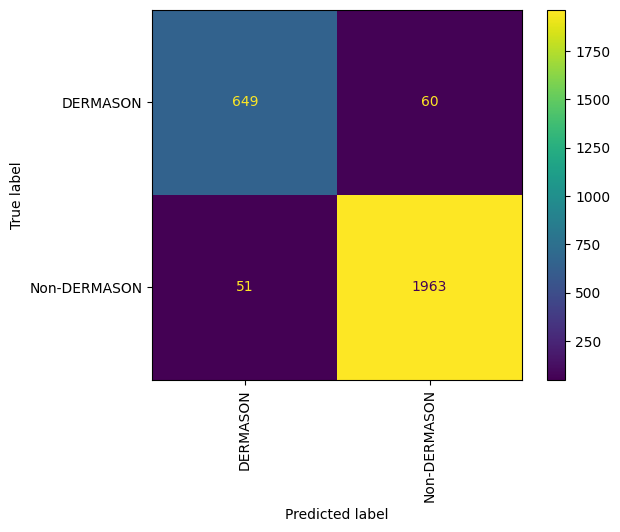

In [19]:
# Mode function returns the values that appear most frequently in the array
y_pred = stats.mode([model.predict(X_test) for model in svc_cv_models]).mode
matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=encoder.inverse_transform([0, 1]),
    xticks_rotation="vertical",
)

results_comparison['SVM'] = get_all_metrics(y_test, y_pred)
results_comparison.loc["Brier Score", "SVM"] = np.mean((y_pred - y_test) ** 2)
results_comparison.loc["Brier Skill Score", "SVM"] = results_comparison["SVM"][
    "Brier Score"
] / (np.mean((y_test - np.mean(y_pred)) ** 2))

## Additional Algorithm - KNN

In [20]:
# params = {
#     "n_neighbors": [3, 5, 7],
#     "weights": ["uniform", "distance"],
#     "algorithm": ["ball_tree", "kd_tree", "brute"],
#     "leaf_size": [10, 30, 50],
#     "p": [1, 2, 3],
# }
stratified_split = StratifiedShuffleSplit(n_splits=6, test_size=0.1, random_state=42)
# gridsearch_knn = GridSearchCV(
#     KNeighborsClassifier(n_jobs=-1),
#     params,
#     cv=stratified_split,
#     n_jobs=-1,
#     verbose=1,
#     scoring=custom_calculate_f1_score
# )
# gridsearch_knn.fit(X_train, y_train)
# gridsearch_knn.best_params_

# If you uncomment the commented code above, you will get the following output
# Output - {'algorithm': 'ball_tree',
#  'leaf_size': 10,
#  'n_neighbors': 5,
#  'p': 2,
#  'weights': 'distance'}

Fitting 6 folds for each of 162 candidates, totalling 972 fits


{'algorithm': 'ball_tree',
 'leaf_size': 10,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'distance'}

In [21]:
knn_cv = {}
knn_cv_models = []

for i, (train_index, test_index) in enumerate(stratified_split.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    knn = KNeighborsClassifier(
        algorithm="ball_tree",
        leaf_size=10,
        n_neighbors=5,
        p=2,
        weights="distance",
        n_jobs=-1,
    )
    knn.fit(X_train_fold, y_train_fold)

    y_pred = knn.predict(X_val_fold)
    y_pred_proba = knn.predict_proba(X_val_fold)[:, 1]
    knn_cv[i + 1] = get_all_metrics(y_val_fold, y_pred)
    knn_cv[i+1]['Brier Score'] = np.mean((y_pred_proba - y_val_fold)**2)
    knn_cv[i+1]['Brier Skill Score'] = knn_cv[i+1]['Brier Score'] / (np.mean((y_val_fold - np.mean(y_pred_proba))**2))
    knn_cv_models.append(knn)

knn_cv["mean"] = pd.DataFrame(knn_cv).mean(axis=1)
pd.DataFrame(knn_cv).round(4)

,1,2,3,4,5,6,mean
TP,261.0000,264.0000,257.0000,255.0000,260.0000,265.0000,260.3333
TN,780.0000,775.0000,783.0000,785.0000,779.0000,786.0000,781.3333
FP,25.0000,30.0000,22.0000,20.0000,26.0000,19.0000,23.6667
FN,23.0000,20.0000,27.0000,29.0000,24.0000,19.0000,23.6667
P,284.0000,284.0000,284.0000,284.0000,284.0000,284.0000,284.0000
N,805.0000,805.0000,805.0000,805.0000,805.0000,805.0000,805.0000
TPR,0.9190,0.9296,0.9049,0.8979,0.9155,0.9331,0.9167
TNR,0.9689,0.9627,0.9727,0.9752,0.9677,0.9764,0.9706
FPR,0.0311,0.0373,0.0273,0.0248,0.0323,0.0236,0.0294
FNR,0.0810,0.0704,0.0951,0.1021,0.0845,0.0669,0.0833


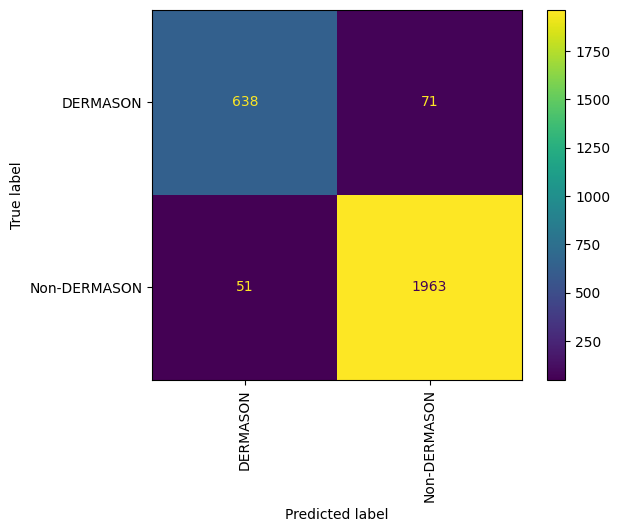

In [22]:
# Mode function returns the values that appear most frequently in the array
y_pred = stats.mode([model.predict(X_test) for model in knn_cv_models]).mode
matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=encoder.inverse_transform([0, 1]),
    xticks_rotation="vertical",
)

results_comparison['KNN'] = get_all_metrics(y_test, y_pred)
results_comparison.loc["Brier Score", "KNN"] = np.mean((y_pred - y_test) ** 2)
results_comparison.loc["Brier Skill Score", "KNN"] = results_comparison["KNN"][
    "Brier Score"
] / (np.mean((y_test - np.mean(y_pred)) ** 2))

## Additional Deep Learning Algorithm - Conv1D

In [23]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device for torch models")

Using mps device for torch models


In [24]:
class Conv1DNNModel(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1d_relu_stack = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Flatten(),
            nn.Linear(32 * 10, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.conv1d_relu_stack(x)

In [25]:
learning_rate = 1e-2
batch_size = 64
epochs = 20

conv1d_model = Conv1DNNModel()
loss_fn = nn.BCEWithLogitsLoss()
summary(conv1d_model, input_size=(batch_size, 1, 16))

Layer (type:depth-idx)                   Output Shape              Param #
Conv1DNNModel                            [64, 2]                   --
├─Sequential: 1-1                        [64, 2]                   --
│    └─Conv1d: 2-1                       [64, 128, 14]             512
│    └─ReLU: 2-2                         [64, 128, 14]             --
│    └─BatchNorm1d: 2-3                  [64, 128, 14]             256
│    └─Conv1d: 2-4                       [64, 64, 12]              24,640
│    └─ReLU: 2-5                         [64, 64, 12]              --
│    └─BatchNorm1d: 2-6                  [64, 64, 12]              128
│    └─Conv1d: 2-7                       [64, 32, 10]              6,176
│    └─ReLU: 2-8                         [64, 32, 10]              --
│    └─BatchNorm1d: 2-9                  [64, 32, 10]              64
│    └─Flatten: 2-10                     [64, 320]                 --
│    └─Linear: 2-11                      [64, 64]                  20,544
│

In [26]:
y_train_one_hot = pd.get_dummies(y_train.values, dtype=np.float32)
y_test_one_hot = pd.get_dummies(y_test.values, dtype=np.float32)

test_dataset = TensorDataset(
    torch.tensor(X_test.values.reshape((-1, 1, 16)), dtype=torch.float32),
    torch.tensor(y_test.values, dtype=torch.float32),
)

In [27]:
stratified_cv_split = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=42)

conv1d_cv = TorchKFoldCrossValidation(
    model_class=Conv1DNNModel,
    loss_fn=loss_fn,
    learning_rate=learning_rate,
    batch_size=batch_size,
    epochs=epochs,
    cv=stratified_cv_split,
    device=device
)
conv1d_cv.fit(X_train.values.reshape(-1,1,16), y_train_one_hot.values)

## Load models, it is faster than to train the model again
## If you want to train the model then comment out the below line and uncomment the above code line
# conv1d_cv.load_models()

Cross validation step 1

Epoch 1
-------------------------------
Model saved with F1 Score: 0.9195804195804196
Epoch 1 completed

Epoch 2
-------------------------------
Epoch 2 completed

Epoch 3
-------------------------------
Epoch 3 completed

Epoch 4
-------------------------------
Model saved with F1 Score: 0.9206349206349206
Epoch 4 completed

Epoch 5
-------------------------------
Model saved with F1 Score: 0.9228070175438596
Epoch 5 completed

Epoch 6
-------------------------------
Model saved with F1 Score: 0.9233511586452763
Epoch 6 completed

Epoch 7
-------------------------------
Epoch 7 completed

Epoch 8
-------------------------------
Model saved with F1 Score: 0.927797833935018
Epoch 8 completed

Epoch 9
-------------------------------
Epoch 9 completed

Epoch 10
-------------------------------
Epoch 10 completed

Epoch 11
-------------------------------
Epoch 11 completed

Epoch 12
-------------------------------
Epoch 12 completed

Epoch 13
-----------------------

,1,2,3,4,5,6,7,8,9,10,mean
TP,258,259,269,264,264,272,261,257,258,266,262.8
TN,788,793,784,779,786,783,774,783,788,779,783.7
FP,17,12,21,26,19,22,31,22,17,26,21.3
FN,26,25,15,20,20,12,23,27,26,18,21.2
P,284,284,284,284,284,284,284,284,284,284,284.0
N,805,805,805,805,805,805,805,805,805,805,805.0
TPR,0.908451,0.911972,0.947183,0.929577,0.929577,0.957746,0.919014,0.90493,0.908451,0.93662,0.925352
TNR,0.978882,0.985093,0.973913,0.967702,0.976398,0.972671,0.961491,0.972671,0.978882,0.967702,0.97354
FPR,0.021118,0.014907,0.026087,0.032298,0.023602,0.027329,0.038509,0.027329,0.021118,0.032298,0.02646
FNR,0.091549,0.088028,0.052817,0.070423,0.070423,0.042254,0.080986,0.09507,0.091549,0.06338,0.074648


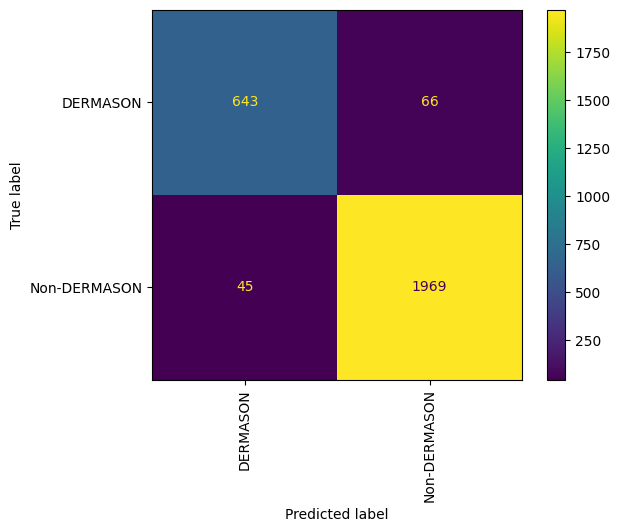

In [28]:
y_pred = conv1d_cv.predict(test_dataset.tensors[0]).argmax(axis=1)
matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=encoder.inverse_transform([0, 1]),
    xticks_rotation="vertical",
)

results_comparison["Conv1D-NN"] = get_all_metrics(y_test, y_pred)
results_comparison.loc["Brier Score", "Conv1D-NN"] = np.mean((y_pred - y_test) ** 2)
results_comparison.loc["Brier Skill Score", "Conv1D-NN"] = results_comparison["Conv1D-NN"][
    "Brier Score"
] / (np.mean((y_test - np.mean(y_pred)) ** 2))

# Results

In [29]:
# Result comparison on the test dataset for all the models
results_comparison.round(4)

,RandomForest,SVM,KNN,Conv1D-NN
TP,641.0000,649.0000,638.0000,643.0000
TN,1960.0000,1963.0000,1963.0000,1969.0000
FP,54.0000,51.0000,51.0000,45.0000
FN,68.0000,60.0000,71.0000,66.0000
P,709.0000,709.0000,709.0000,709.0000
N,2014.0000,2014.0000,2014.0000,2014.0000
TPR,0.9041,0.9154,0.8999,0.9069
TNR,0.9732,0.9747,0.9747,0.9777
FPR,0.0268,0.0253,0.0253,0.0223
FNR,0.0959,0.0846,0.1001,0.0931
